This will be the main notebook, where data is loaded, investigated, prepared, and models are build, trained and experimented with.

In [121]:
import os
import cv2
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.datasets import VOCDetection
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_curve, auc
from torchvision.ops import box_iou
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
import pandas as pd

In [122]:
root = 'Kvasir-SEG'
imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
annotations = list(sorted(os.listdir(os.path.join(root, "bbox"))))
img_name = imgs[0]
img_id = os.path.splitext(img_name)[0]
ann_path = os.path.join(root, "bbox", img_id + ".csv")
raw = pd.read_csv(ann_path)
print(f'{raw["xmin"].iloc[0]}')


38


In [123]:
class KvasirPolypYOLODataset(Dataset):
    """
    Dataset for Kvasir-SEG in YOLO format.

    __getitem__ returns:
        - image: Tensor (3, H, W) float32 in [0, 1]
        - targets: Tensor (N, 5) with [class, x_center, y_center, w, h] normalized
                  (N = number of bboxes for that image, can be 0)
    """

    def __init__(self, root):
        self.root = root # Root path where the dataset is located
        # Define paths for image and annotation directories
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "bbox"))))

    def __getitem__(self, idx):
        # Index the image/annoation with `idx`and obtain the annotations
        img_name = self.imgs[idx]
        img_id = os.path.splitext(img_name)[0]

        img_path = os.path.join(self.root, "images", img_name)
        ann_path = os.path.join(self.root, "bbox", img_id + ".csv")

        img = Image.open(img_path).convert("RGB")
        img = torchvision.transforms.ToTensor()(img)

        # CSV: class,xmin,ymin,xmax,ymax (with header)
        ann = pd.read_csv(ann_path)
        labels = ann['class_name'].map({"polyp": 1}).fillna(0).to_numpy()  # Map class names to numbers
        boxes = ann[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy().astype(np.float32)  # Extract bounding boxes

        # Convert to tensors boxes and labels
        boxes = torch.as_tensor(boxes, dtype=torch.float32)  #convert boxes to tensor in format float32
        #convert labels to tensor (format int64) but previously convert names to numbers: "RBC"=1, "WBC=2" and the remainder label= 3
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Ensure target has valid annotations
        if len(boxes) == 0:
            # Add a dummy box if no valid boxes exist (to avoid crashing the model)
            boxes = torch.as_tensor([[0.0, 0.0, 1.0, 1.0]], dtype=torch.float32)
            labels = torch.as_tensor([0], dtype=torch.int64)  # Label 0 for "background"

        xmin = boxes[:,0]
        ymin = boxes[:,1]
        xmax = boxes[:,2]
        ymax = boxes[:,3]

        keep = (xmax > xmin) & (ymax > ymin)
        boxes = boxes[keep]
        labels = labels[keep]
        target = {
            "boxes": boxes,
            "labels": labels,
        }

        return img,target,img_id  # return image, target dict, and image id (image identifier)
    def __len__(self):
        # return the length of the dataset
        return len(self.imgs)

In [124]:
root = 'Kvasir-SEG'
dataset = KvasirPolypYOLODataset(root)
print(f"Dataset size: {len(dataset)} images")
# Visualize a sample


Dataset size: 1000 images


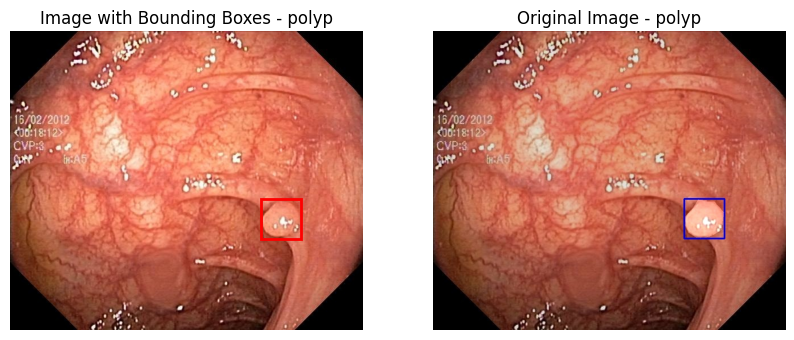

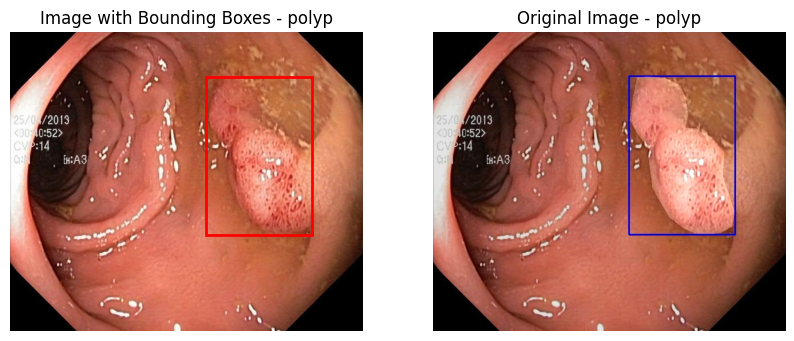

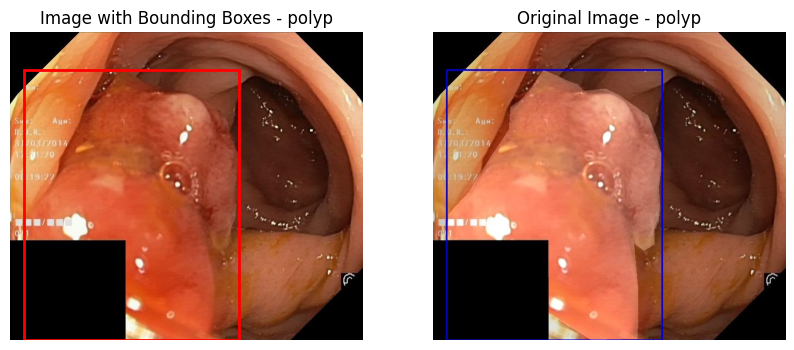

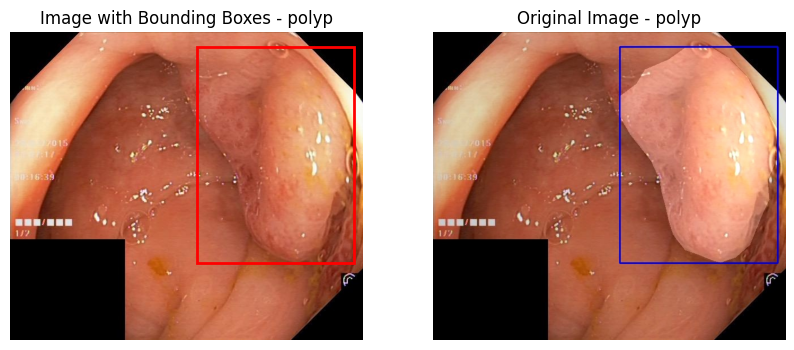

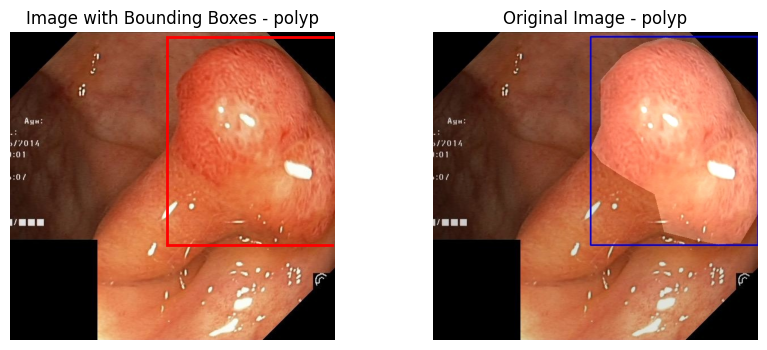

In [125]:
def plot_image_with_boxes(img,root,img_id,target):
    """
    Plots an image with bounding boxes.

    Args:
        img (Tensor): Image tensor of shape (3, H, W).
        boxes (Tensor): Bounding boxes tensor of shape (N, 4) in (xmin, ymin, xmax, ymax) format.
        img_id (str): Image identifier.
        target (dict): Target dictionary containing boxes and labels.
    """
    img_with_boxes = os.path.join(root, "annotated_images", img_id + ".jpg")
    img_with_boxes = Image.open(img_with_boxes).convert("RGB")
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    img = img.permute(1, 2, 0).numpy()  # Convert to (H, W, 3) for plotting
    ax[0].imshow(img)
    ax[0].axis('off')

    for box, label in zip(target['boxes'], target['labels']):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
        labels = 'polyp' if label.item() == 1 else 'background'
        ax[0].set_title(f'Image with Bounding Boxes - {labels}')
        ax[1].imshow(img_with_boxes)

        ax[1].set_title(f'Original Image - {labels}')
        ax[1].axis('off')

    plt.show()
for i in range(5):
  img_, target_, img_id_ = dataset[i+100]
  plot_image_with_boxes(img_, root, img_id_, target_)

## Data Analysing

In [128]:
total_boxes = 0
for _, target, _ in dataset:
    total_boxes += target["boxes"].shape[0]

print("Total bounding boxes:", total_boxes)


Total bounding boxes: 1071


Checking, if some images have multiple bounding boxes:

In [130]:
for img, target, img_id in dataset:
    n_boxes = target["boxes"].shape[0]
    if n_boxes > 1:
        print(f"{img_id}: {n_boxes} bounding boxes")


cju0roawvklrq0799vmjorwfv: 3 bounding boxes
cju0sr5ghl0nd08789uzf1raf: 2 bounding boxes
cju15jr8jz8sb0855ukmkswkz: 2 bounding boxes
cju183od81ff608017ekzif89: 2 bounding boxes
cju1cu1u2474n0878tt7v4tdr: 2 bounding boxes
cju2hfqnmhisa0993gpleeldd: 2 bounding boxes
cju2hjrqcvi2j0801bx1i6gxg: 2 bounding boxes
cju2ma647l0nj0993ot4deq2q: 2 bounding boxes
cju2nqapmzvk20801f9us40dx: 2 bounding boxes
cju2rnkt22xep0801as160g9t: 2 bounding boxes
cju2rz4k434s70855wwx3ddtx: 2 bounding boxes
cju2ueb6j5ado0878vf5md13o: 2 bounding boxes
cju2uzabhs6er0993x3aaf87p: 2 bounding boxes
cju2y5zas8m7f0801d34g5owq: 2 bounding boxes
cju2zdhsczmn50988z64qwg2q: 2 bounding boxes
cju2zjcvj9qma0801dk71hhi0: 2 bounding boxes
cju2zo0fwzv580988qlijd2xa: 2 bounding boxes
cju30ajhw09sx0988qyahx9s8: 2 bounding boxes
cju31t8xd17bk0835rnb893jk: 2 bounding boxes
cju32a52lb9rc0799xi40qs00: 3 bounding boxes
cju32gzs6xo8x0993r8tedbpb: 2 bounding boxes
cju33belnbyhm0878yxl42233: 2 bounding boxes
cju34xspwzenf0993cyzajv9n: 2 bou

Checking if the multiple bounding boxes are correctly plotted

Visualizing: cju0roawvklrq0799vmjorwfv


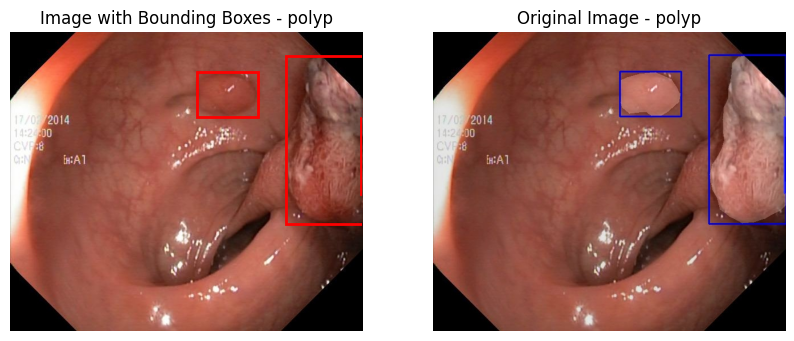

In [132]:
for img, target, img_id in dataset:
    if target["boxes"].shape[0] > 1:
        print("Visualizing:", img_id)

        plot_image_with_boxes(img, root, img_id, target)
        break


Checking if some images have no bounding box at all:

In [ ]:
image_ids = {os.path.splitext(os.path.basename(path))[0] for path in image_paths}
labeled_ids = set(labels_df['id'].unique())
unlabeled_ids = image_ids - labeled_ids
len(unlabeled_ids)  # should be 0 if all images are labeled

0

## Dynamic Data Loader

In [ ]:
class KvasirPolypYOLODataset(Dataset):
    """
    Dataset for Kvasir-SEG in YOLO format.

    __getitem__ returns:
        - image: Tensor (3, H, W) float32 in [0, 1]
        - targets: Tensor (N, 5) with [class, x_center, y_center, w, h] normalized
                  (N = number of bboxes for that image, can be 0)
    """

    def __init__(
        self,
        images_dir,
        labels_df,
        img_size=None,      # optional resizing to (img_size, img_size), 640 is common for YOLO
        default_class=0,    
        transforms=None     # optional add transform
    ):
        super().__init__()

        self.images_dir = images_dir
        self.img_paths = load_images(images_dir)
        self.img_size = img_size
        self.default_class = default_class
        self.transforms = transforms

        # pre-build a dictionary id -> dataframe rows (bboxes)
        # id is the filename without extension (like "image_001")
        self.id_to_boxes = {}
        for img_id, group in labels_df.groupby("id"):
            self.id_to_boxes[img_id] = group.reset_index(drop=True)

        # ensure no images without labels
        image_ids = {os.path.splitext(os.path.basename(p))[0] for p in self.img_paths}
        labeled_ids = set(self.id_to_boxes.keys())
        unlabeled_ids = image_ids - labeled_ids
        print(f"Total images: {len(image_ids)}")
        print(f"Images with at least one bbox: {len(labeled_ids)}")
        print(f"Images without bbox: {len(unlabeled_ids)}")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # image
        img_path = self.img_paths[idx]
        img_id = os.path.splitext(os.path.basename(img_path))[0]

        # read image with cv2 (BGR)
        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"Cannot read image: {img_path}")

        # BGR -> RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        orig_h, orig_w = img.shape[:2]

        # optional resizing (for YOLO often 640x640 or similar)
        if self.img_size is not None:
            img = cv2.resize(img, (self.img_size, self.img_size))
            new_h, new_w = self.img_size, self.img_size
        else:
            new_h, new_w = orig_h, orig_w

        # normalize to [0,1] and change to (C,H,W)
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # (H,W,C) -> (C,H,W)
        img_tensor = torch.from_numpy(img)  # img tensor

        # all bboxes for this image, None if no bboxes
        df_boxes = self.id_to_boxes.get(img_id, None)

        targets = []

        if df_boxes is not None and len(df_boxes) > 0:
            for _, row in df_boxes.iterrows():
                xmin = float(row["xmin"])
                ymin = float(row["ymin"])
                xmax = float(row["xmax"])
                ymax = float(row["ymax"])

                # if resized, scale the coordinates
                if self.img_size is not None:
                    # scaling factor
                    scale_x = new_w / orig_w
                    scale_y = new_h / orig_h
                    xmin *= scale_x
                    xmax *= scale_x
                    ymin *= scale_y
                    ymax *= scale_y

                # convert to normalized YOLO format
                box_w = xmax - xmin
                box_h = ymax - ymin
                x_center = xmin + box_w / 2.0
                y_center = ymin + box_h / 2.0

                x_center /= new_w
                y_center /= new_h
                box_w    /= new_w
                box_h    /= new_h

                # check for valid boxes
                if box_w <= 0 or box_h <= 0:
                    continue

                # [class, x_center, y_center, w, h]
                targets.append([
                    float(self.default_class),
                    float(x_center),
                    float(y_center),
                    float(box_w),
                    float(box_h),
                ])

        if len(targets) > 0:
            targets = torch.tensor(targets, dtype=torch.float32)
        else:
            # in case of no bboxes put zero-tensor (0,5)
            targets = torch.zeros((0, 5), dtype=torch.float32)

        # optional: implement transformations here (on img and bbox)

        return img_tensor, targets, img_id 

In [ ]:
def yolo_collate_fn(batch):
    """
    Custom collate function for YOLO-format batches.
    
    Takes a list of (image, targets, img_id) tuples and combines them into:
        - images: stacked tensor of shape (B, 3, H, W)
        - all_targets: concatenated tensor of shape (M, 6) where each row is 
          [batch_index, class, x_center, y_center, width, height]
        - img_ids: list of image identifiers
    """
    images = []
    all_targets = []
    img_ids = []

    for i, (img, targets, img_id) in enumerate(batch):
        images.append(img)
        img_ids.append(img_id)

        if targets.numel() > 0:
            # add column with the index of the image in the batch
            batch_idx = torch.full(
                (targets.size(0), 1),
                i,
                dtype=targets.dtype
            )
            # [batch_idx, class, x_c, y_c, w, h]
            t = torch.cat([batch_idx, targets], dim=1)
            all_targets.append(t)

    images = torch.stack(images, dim=0)  # (B,3,H,W)

    if len(all_targets) > 0:
        all_targets = torch.cat(all_targets, dim=0)
    else:
        all_targets = torch.zeros((0, 6), dtype=torch.float32)

    return images, all_targets, img_ids

In [ ]:
dataset = KvasirPolypYOLODataset(
    images_dir=PATH_IMAGES,
    labels_df=labels_df,
    img_size=640,   
    default_class=0,
)

dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,  
    collate_fn=yolo_collate_fn
)

# prova a iterare un batch
for images, targets, img_ids in dataloader:
    print("Batch images shape:", images.shape)  # (B,3,H,W)
    print("Targets shape:", targets.shape)      # (M,6) -> [batch_idx, class, x_c, y_c, w, h]
    print("Example img_ids:", img_ids[:3])
    break

Total images: 1000
Images with at least one bbox: 1000
Images without bbox: 0
